In [1]:
# Call the relevant python packages
import numpy as np
import pandas as pd
import glob, os                          # Operating system module and pathnames

import matplotlib
#matplotlib.use('nbagg')
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.io import ascii, fits
from astropy.table import join, hstack, Table, Column, vstack
from astropy.coordinates import Angle, Latitude, Longitude, SkyCoord

#import SED Fitter module
from sedfitter import fit, plot, plot_params_1d, plot_params_2d
from sedfitter import filter_output, write_parameters, write_parameter_ranges
from sedfitter.extinction import Extinction

# Set colour palette & plot layouts
import seaborn as sns     #; sns.set()
sns.set_context("paper")   # "paper", "notebook", "talk", "poster"

# Output plots in Notebook
#%matplotlib notebook
%matplotlib inline

In [2]:
# Read in the catalogue
file = '/scratch/s1625982/NGC6822/env/NGC6822_filtered.csv'
data = ascii.read(file, data_start=1)

# Print the number of YSOs found in the imported table
YSO_num=len(data)
print("The number of YSOs in the table is",YSO_num)

# Set up new columns for the flux
data['J flux']=0.
data['H flux']=0.
data['K flux']=0.
data['36 flux']=0.
data['45 flux']=0.
data['58 flux']=0.
data['80 flux']=0.
data['24 flux']=0.

# Set up new columns for the flux errors
# By default set error as 0.2
data['J flux err']=0.2
data['H flux err']=0.2
data['K flux err']=0.2
data['36 flux err']=0.2
data['45 flux err']=0.2
data['58 flux err']=0.2
data['80 flux err']=0.2
data['24 flux err']=0.2

# Set up new columns for the integer assigned to each source (0-4).
# NB: this program assumes sources are either valid or upper limits.
# Hence, flags are either 1 (valid) or 3 (upper limit).
# Assume all sources to be valid initially
data['J int']=1
data['H int']=1
data['K int']=1
data['36 int']=1
data['45 int']=1
data['58 int']=1
data['80 int']=1
data['24 int']=1

# Assign the integer describing source reliability
def write_column(idx,name,flag):
    for i in range(len(idx[0])):
        #if source is upper limit write 3 flag
        #if source is bad photometry write 0 flag
        data[name][idx[0][i]]=flag

# Set up a new column for sources having 2JHK, 36, 45 but no 80 or 24
data['confused?']=0
idx_confused=np.where((data['HJKNum']>=2)&(data['36 data?']==1)&(data['45 data?']==1)&(data['24 data?']==0)&(data['80 data?']==0))
write_column(idx_confused,'confused?',1)
print("Th number of sources with 2 of JHK, 36 and 45 but no 80 or 24 micron flux is",len(idx_confused[0]))

err=0.2
# Create indices to find which sources are upper limits
idx_UL_J=np.where(((data['eJmag']<=0)|(data['eJmag']>err))&(data['Jmag']>0))
write_column(idx_UL_J,'J int',3)
idx_UL_H=np.where(((data['eHmag']<=0)|(data['eHmag']>err))&(data['Hmag']>0))
write_column(idx_UL_H,'H int',3)
idx_UL_K=np.where(((data['eKmag']<=0)|(data['eKmag']>err))&(data['Kmag']>0))
write_column(idx_UL_K,'K int',3)
idx_UL_36=np.where(((data['e36mag']<=0)|(data['e36mag']>err))&(data['k36mag']>0))
write_column(idx_UL_36,'36 int',3)
idx_UL_45=np.where(((data['e45mag']<=0)|(data['e45mag']>err))&(data['k45mag']>0))
write_column(idx_UL_45,'45 int',3)
idx_UL_58=np.where(((data['e58mag']<=0)|(data['e58mag']>err))&(data['k58mag']>0))
write_column(idx_UL_58,'58 int',3)
idx_UL_80=np.where(((data['e80mag']<=0)|(data['e80mag']>err))&(data['k80mag']>0))
write_column(idx_UL_80,'80 int',3)
idx_UL_24=np.where(((data['e24mag']<=0)|(data['e24mag']>err))&(data['k24mag']>0))
write_column(idx_UL_24,'24 int',3)

# Create indices to find which sources are bad photometry
idx_BP_J=np.where(((data['eJmag']<=0)|(data['eJmag']>err))&(data['Jmag']<=0))
write_column(idx_BP_J,'J int',0)
idx_BP_H=np.where(((data['eHmag']<=0)|(data['eHmag']>err))&(data['Hmag']<=0))
write_column(idx_BP_H,'H int',0)
idx_BP_K=np.where(((data['eKmag']<=0)|(data['eKmag']>err))&(data['Kmag']<=0))
write_column(idx_BP_K,'K int',0)
idx_BP_36=np.where(((data['e36mag']<=0)|(data['e36mag']>err))&(data['k36mag']<=0))
write_column(idx_BP_36,'36 int',0)
idx_BP_45=np.where(((data['e45mag']<=0)|(data['e45mag']>err))&(data['k45mag']<=0))
write_column(idx_BP_45,'45 int',0)
idx_BP_58=np.where(((data['e58mag']<=0)|(data['e58mag']>err))&(data['k58mag']<=0))
write_column(idx_BP_58,'58 int',0)
idx_BP_80=np.where(((data['e80mag']<=0)|(data['e80mag']>err))&(data['k80mag']<=0))
write_column(idx_BP_80,'80 int',0)
idx_BP_24=np.where(((data['e24mag']<=0)|(data['e24mag']>err))&(data['k24mag']<=0))
write_column(idx_BP_24,'24 int',0)

# Hardcode zero points of filters for Vega system.
# Fluxes and their errors are given in mJy
F_0_J, F_0_err_J, m_0_J = 1601000, 0.0, -0.016
F_0_H, F_0_err_H, m_0_H = 1034000, 0.0, 0.018
F_0_K, F_0_err_K, m_0_K = 670300, 0.0, 0.008
F_0_36, F_0_err_36, m_0_36 = 280900, 4100, 0.0
F_0_45, F_0_err_45, m_0_45 = 179700, 2600, 0.0
F_0_58, F_0_err_58,m_0_58 = 115000, 1700, 0.0
F_0_80, F_0_err_80, m_0_80 = 1034000, 900, 0.0
F_0_24, F_0_err_24, m_0_24 = 64900, 110, 0.0

# Define lists for Fv, Fv_0, m_0 etc.
int_list = ['J int','H int','K int','36 int','45 int','58 int','80 int','24 int']
flux_list = ['J flux','H flux','K flux','36 flux','45 flux','58 flux','80 flux','24 flux']
flux_err_list = ['J flux err','H flux err','K flux err','36 flux err','45 flux err','58 flux err','80 flux err','24 flux err']
F_0_list = [F_0_J,F_0_H,F_0_K,F_0_36,F_0_45,F_0_58,F_0_80,F_0_24]
F_0_err_list = [F_0_err_J,F_0_err_H,F_0_err_K,F_0_err_36,F_0_err_45,F_0_err_58,F_0_err_80,F_0_err_24]
m_0_list = [m_0_J,m_0_H,m_0_K,m_0_36,m_0_45,m_0_58,m_0_80,m_0_24]
mag_list = ['Jmag','Hmag','Kmag','k36mag','k45mag','k58mag','k80mag','k24mag']
mag_err_list = ['eJmag','eHmag','eKmag','e36mag','e45mag','e58mag','e80mag','e24mag']

# Write flux and flux error calculations out for each source in each filter
for i in range(len(flux_list)):
        data[flux_list[i]]=F_0_list[i]*np.power(10,0.4*(m_0_list[i]-data[mag_list[i]]))
        #data[flux_err_list[i]]=data[flux_list[i]]*np.sqrt((np.square(0.921*data[mag_err_list[i]]))-np.square(F_0_err_list[i]/F_0_list[i]))
        for j in range(YSO_num):
            if data[int_list[i]][j]==3:
                data[flux_err_list[i]][j]=1.0
            else:
                data[flux_err_list[i]][j]=0.1*data[flux_list[i]][j]

The number of YSOs in the table is 518
Th number of sources with 2 of JHK, 36 and 45 but no 80 or 24 micron flux is 0


In [ ]:
# Write out table in the right format for SED fitter
ascii.write(data[['New name','RA','Dec','J int','H int','K int','36 int','45 int','58 int','80 int','24 int',
                  'J flux','J flux err','H flux','H flux err','K flux','K flux err','36 flux','36 flux err',
                  '45 flux','45 flux err','58 flux','58 flux err','80 flux','80 flux err','24 flux','24 flux err']],
            'NGC6822_YSOs_SED_format.txt', format='no_header', fast_writer=False)

# NB: THE USER IS REQUIRED TO FIND AND REPLACE 'INF' IN THE FILE WITH WHATEVER THEY WISH TO USE
#     TO DENOTE UPPER LIMITS (E.G. -9999)

In [4]:
# Define path to models
model_dir = '/scratch/s1625982/NGC6822/env/models_r06'

# Read in extinction law)
extinction = Extinction.from_file('/scratch/s1625982/NGC6822/env/Input_SED/kmh94.par',
                                  columns=[0, 3], wav_unit=u.micron, chi_unit=u.cm**2 / u.g)

# Define filters and apertures
filters = ['2J', '2H', '2K', 'I1', 'I2', 'I3', 'I4', 'M1']
apertures = [2., 2., 2., 1.2, 1.2, 1.2, 1.2, 6.] * u.arcsec


# Run the fitting
# YSO 2006 models take a long time to run - too long for the kernel to run in one go
# Define start and end sources to run - the user must have trimmed the master table to the appropriate limits
# Creates an output file which can be saved and plotted later
start_source = str(155)
end_source = str(155)
SED_input_file = '/scratch/s1625982/NGC6822/env/Input_SED/'+start_source+'to'+end_source+'.txt'
#SED_input_file = '/scratch/s1625982/NGC6822/env/NGC6822_YSOs_SED_format.txt'
SED_output_file = '/scratch/s1625982/NGC6822/env/Output_SED/YSO_2006/'+start_source+'to'+end_source+'.fitinfo'
#SED_output_file = '/scratch/s1625982/NGC6822/env/Full_output.fitinfo'
data = ascii.read(SED_input_file, data_start=1)
fit(SED_input_file, filters, apertures, model_dir,
    SED_output_file,
    extinction_law=extinction,
    distance_range=[450., 530.] * u.kpc,    # Distance range here is for NGC 6822
    av_range=[0., 40.])                      # A_V range here is for NGC 6822

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  YSO models
   Log[d] stepping     :  0.01
   Number of distances :  8

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

   Reading /scratch/s1625982/NGC6822/env/models_r06/convolved/2J.fits
   Reading /scratch/s1625982/NGC6822/env/models_r06/convolved/2H.fits
   Reading /scratch/s1625982/NGC6822/env/models_r06/convolved/2K.fits
   Reading /scratch/s1625982/NGC6822/env/models_r06/convolved/I1.fits
   Reading /scratch/s1625982/NGC6822/env/models_r06/convolved/I2.fits
   Reading /scratch/s1625982/NGC6822/env/models_r06/convolved/I3.fits
   Reading /scratch/s1625982/NGC6822/env/models_r06/convolved/I4.fits
   Reading /scratch/s1625982/NGC6822/env/models_r06/convolved/M1.fits
 -------------------------------------

In [5]:
# Plot the fits for the output file using the "delta X^2 < 3" format 
from sedfitter import plot
plot(SED_output_file, '/scratch/s1625982/NGC6822/env/155to155', select_format=('F', 3))

Delete directory /scratch/s1625982/NGC6822/env/155to155? [y/[n]] y



In [8]:
# Filter an output file by the value of Xbest^2.
# Those with a X^2 greater than the second parameter will be sorted to _good file
filter_output('/scratch/s1625982/NGC6822/env/Output_SED/501to584.fitinfo', chi=100.)

# Plot specific outputs to a specific folder
plot('/scratch/s1625982/NGC6822/env/Output_SED/501to584.fitinfo_good',
     '/scratch/s1625982/NGC6822/env/Output_SED/501to584good')

In [12]:
# Plot a graph of parameters
parameter1 = 'RSTAR'
parameter2 = 'TSTAR'
path1 = '2006_YSO_'+parameter1+'1to100'
path2 = '2006_YSO_'+parameter1+'_and_'+parameter2+'1to100'

#plot_params_1d('/scratch/s1625982/NGC6822/env/Output_SED/1to100.fitinfo', parameter1, path1)
plot_params_2d('/scratch/s1625982/NGC6822/env/Output_SED/1to100.fitinfo', parameter1, parameter2, path2)

In [2]:
# Write parameters to txt file.
# NB: open the file in Excel and choose 'merge delimiters' to make it more coherent

import sedfitter
input_param_file = '/scratch/s1625982/NGC6822/env/Output_SED/YSO_2006/1to100.fitinfo'
output_param_file = '/scratch/s1625982/NGC6822/env/Output_SED/YSO_2006/params1to100.txt'
write_parameters(input_param_file, output_param_file,select_format=('F', 3.))

In [2]:
# Write parameter ranges to txt file.
# NB: open the file in Excel and choose 'merge delimiters' to make it more coherent

import sedfitter
input_param_file = '/scratch/s1625982/NGC6822/env/Output_SED/YSO_2006/1to100.fitinfo'
output_param_file = '/scratch/s1625982/NGC6822/env/Output_SED/YSO_2006/param_ranges1to100.txt'
write_parameter_ranges(input_param_file, output_param_file,select_format=('F', 3.))

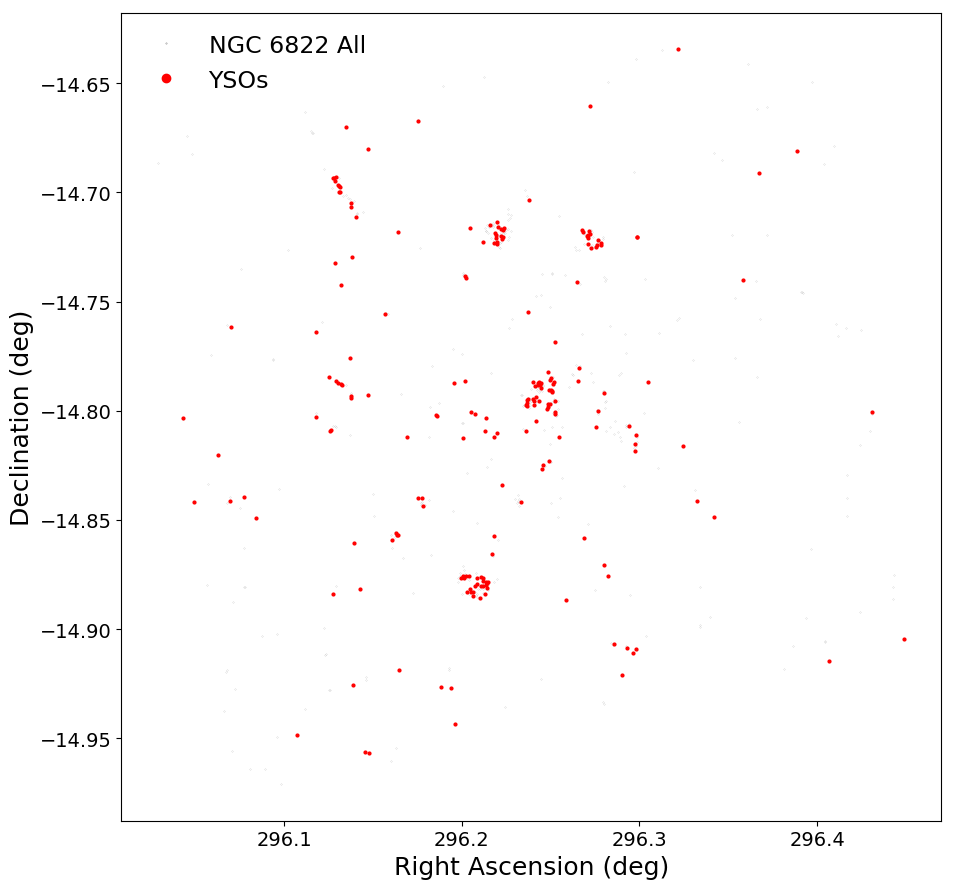

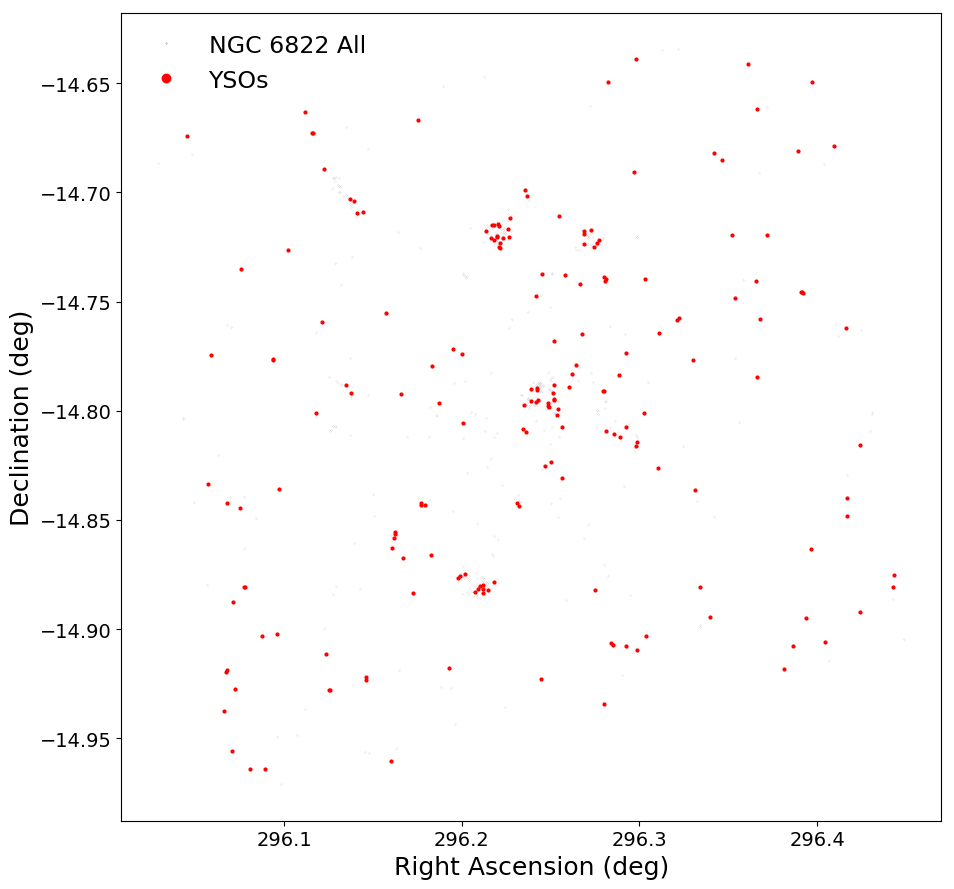

In [25]:
def location_plot(sp_idx,plot_idx):
    # Plot the cataloge data on the sky
    # Setting up plotting sizes
    # plt.rc("text",  usetex=True)         # Allows latex commands
    plt.rcParams.update(plt.rcParamsDefault)       #Keeps the background white
    plt.rc('font', family='sans-serif')
    plt.rc("xtick", labelsize=14)
    plt.rc("ytick", labelsize=14)
    plt.rc("axes", labelsize=14)
    plt.rc("legend", fontsize=17)
    # plt.rcdefaults()                    # Resets the parameters to their default values
    
    
    # Setting up figure
    plt.figure(figsize=(18,9))
    ax = plt.gca()                        # Sets up active plot region
    
    #Make 1st diagram for 1st reliable catalogue
    plt.subplot(1,2,1)
    # Make the actual plot
    plt.plot(reliable_cat['RA'], reliable_cat['Dec'], '.', color='grey', ms=0.2, label="NGC 6822 All")
    
    #overplot all reliable sources that meet the cut
    plt.plot(reliable_cat['RA'][plot_idx], reliable_cat['Dec'][plot_idx], '.', color='red', ms=4, label="YSOs")
    
    plt.xlabel('Right Ascension (deg)', size=18)
    plt.ylabel('Declination (deg)', size=18)
    
    # Add a legend and a title
    plt.legend(loc="upper left",frameon=False, scatterpoints=1, numpoints=1, markerscale=3.)
    
    #plt.savefig("bla.pdf", bbox_inches='tight')    # Saves the figure is uncommented
    plt.tight_layout()
    plt.show()
    plt.close()
    
table_file = '/scratch/s1625982/NGC6822/env/NGC6822_YSOs.csv'
table = ascii.read(table_file, data_start=1)

reliable_idx=((table['SpNum']>=3)|((table['HJKNum']>=2) & (table['45 data?']==1) & (table['36 data?']==1)))
reliable_cat=table[reliable_idx]
idx_rel_score=np.where(reliable_cat['YSO Score']>=3)

#idx_to_plot = ascii.read('/scratch/s1625982/NGC6822/env/sp_bad_loc.txt', data_start=1)

import numpy as np
idx_to_plot_YSO = np.array([1,5,9,16,17,25,28,38,45,46,53,54,56,59,60,61,62,64,65,66,69,70,72,73,74,75,76,77,78,82,86,88,89,91,92,93,94,95,97,
                       100,102,105,106,107,110,116,120,123,124,125,126,129,132,133,137,139,146,147,149,153,156,157,162,170,172,174,175,177,178,179,180,186,187,188,189,190,191,192,194,195,
                       201,202,205,207,208,210,211,213,215,219,220,221,223,224,226,229,232,235,240,245,246,248,250,251,252,253,254,256,258,261,270,271,272,273,275,277,279,
                       301,308,309,311,313,314,316,317,318,325,326,327,328,329,332,334,338,340,342,343,347,349,351,354,355,362,363,364,367,369,371,373,374,378,380,382,384,388,393,397,398,399,
                       400,407,412,419,420,422,425,427,430,434,435,436,438,440,441,442,444,452,453,457,459,460,462,463,471,472,479,485,493,
                       501,502,505,508,509,510,511,514,516,522,527,529,532,537,544,549,555,566,578,583])
location_plot(idx_rel_score,idx_to_plot_YSO)

idx_to_plot_SP = np.array([3,7,8,10,11,12,13,18,19,20,21,22,24,26,27,29,30,31,32,34,35,37,39,42,43,44,47,49,51,52,55,80,85,87,96,98,
                           101,103,104,111,113,115,117,118,119,127,128,130,131,135,136,140,144,145,148,151,155,159,161,166,167,176,193,
                           203,206,209,212,214,222,233,238,239,244,247,249,255,257,262,264,265,266,267,276,286,289,290,295,298,
                           304,306,307,310,312,323,324,331,333,335,337,339,350,353,359,365,366,368,377,387,391,394,395,396,
                           402,404,406,409,410,411,413,414,417,424,426,428,429,432,445,450,451,456,461,464,468,469,470,474,476,478,480,483,484,486,489,490,496,498,499,
                           506,512,513,515,517,519,520,521,523,524,526,528,530,531,534,536,538,539,540,542,545,546,547,548,550,552,553,554,556,557,558,559,560,561,562,565,567,570,571,572,574,575,581,582])
                
location_plot(idx_rel_score,idx_to_plot_SP)
